In [1]:
from Eval_basis import *
import pandas as pd
import torch

[2019-08-10 13:55:59,019] INFO - scvi._settings | Added StreamHandler with custom formatter to 'scvi' logger.
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


In [2]:
np.random.seed(1)
%matplotlib inline

In [3]:


data_full = EbiData("./data", experiment="E-ENAD-15")
data_big_mapped = UnionDataset("./data", map_fname="ensembl_mouse_genes-proteincoding", low_memory=False)
data_big_mapped.concat_union_from_memory([data_full])
data_big_mapped.filter_cell_types(np.array([ct for ct in data_big_mapped.cell_types if ct != "not available"]))

[2019-08-10 13:57:05,660] WARNING - scvi.dataset.dataset | This dataset has some empty cells, this might fail scVI inference.Data should be filtered with `my_dataset.filter_cells_by_count()
[2019-08-10 13:57:05,701] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2019-08-10 13:57:05,703] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2019-08-10 13:57:06,816] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2019-08-10 13:57:07,923] INFO - scvi.dataset.dataset | Downsampled from 50896 to 35577 cells
[2019-08-10 13:58:47,838] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2019-08-10 13:58:47,839] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2019-08-10 13:58:48,959] INFO - scvi.dataset.dataset | Downsampled from 35577 to 31394 cells


In [4]:
agg = data_full.obs.groupby(["Sample Characteristic[organism part]", "cell_types"]).size()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(agg.sort_index())

Sample Characteristic[organism part]      cell_types                                        
aorta                                     endothelial cell                                       188
                                          erythrocyte                                             91
                                          fibroblast                                              70
                                          not available                                          694
                                          professional antigen presenting cell                    59
ascending colon                           Brush cell of epithelium proper of large intestine      53
                                          enterocyte of epithelium of large intestine            761
                                          enteroendocrine cell                                    29
                                          epithelial cell of large intestine                    141

In [5]:
n_epochs = 100
colors = None
tissue = 'hippocampus'
print("Training VAE for tissue ", tissue)
cutout_cts = agg[tissue].index.values
if "not available" in cutout_cts:
    cutout_cts = np.delete(cutout_cts, np.where(cutout_cts == "not available")[0])
rem_ct = data_big_mapped.cell_types[~np.isin(data_big_mapped.cell_types, cutout_cts)]
data_small = copy.deepcopy(data_big_mapped)
data_big = copy.deepcopy(data_big_mapped)
data_small.filter_cell_types(cutout_cts)
data_big.filter_cell_types(rem_ct)

Training VAE for tissue  hippocampus


[2019-08-10 13:58:49,459] INFO - scvi.dataset.dataset | Downsampled from 31394 to 7482 cells
[2019-08-10 13:58:50,339] INFO - scvi.dataset.dataset | Downsampled from 31394 to 23912 cells


In [6]:
@torch.no_grad()
def show_t_sne(
    self,
    n_samples=1000,
    color_by="",
    colors=None,
    save_name="",
    latent=None,
    batch_indices=None,
    labels=None,
    n_batch=None,
    max_nr_labels=100,
    **kwargs
):
    lgd = None
    # If no latent representation is given
    if latent is None:
        latent, batch_indices, labels = self.get_latent(sample=True)
        latent, idx_t_sne = self.apply_t_sne(latent, n_samples)
        batch_indices = batch_indices[idx_t_sne].ravel()
        labels = labels[idx_t_sne].ravel()
    if not color_by:
        plt.figure(figsize=(10, 10))
        plt.scatter(latent[:, 0], latent[:, 1])
    if color_by == "scalar":
        plt.figure(figsize=(10, 10))
        plt.scatter(latent[:, 0], latent[:, 1], c=labels.ravel())
    else:
        if n_batch is None:
            n_batch = self.gene_dataset.n_batches
        if color_by == "batches" or color_by == "labels":
            indices = (
                batch_indices.ravel() if color_by == "batches" else labels.ravel()
            )
            n = n_batch if color_by == "batches" else self.gene_dataset.n_labels
            if self.gene_dataset.cell_types is not None and color_by == "labels":
                plt_labels = self.gene_dataset.cell_types
            else:
                plt_labels = [str(i) for i in range(len(np.unique(indices)))]
            plt.figure(figsize=(16, 16))
            if colors is None:
                cs = plt.get_cmap("tab20", min(max_nr_labels, n))
                cmap = lambda i, l: cs(i)
            else:
                cmap = lambda i, l: colors[l]
            # prop_cycler = itertools.cycle(mpl.rcParams['axes.prop_cycle'])
            for i, label in zip(range(n), plt_labels):
                # colour = next(prop_cycler)['color']
                color = mpl.colors.to_hex(cmap(i, label))
                print((indices==i).sum())
                print(latent[indices == i, 0], latent[indices == i, 1])
                # if i < max_nr_labels:
                plt.scatter(
                    latent[indices == i, 0], latent[indices == i, 1], c=color, label=label, **kwargs
                )
                # else:
                #     plt.scatter(
                #         latent[indices == i, 0], latent[indices == i, 1], c=color, **kwargs
                #     )
            lgd = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
                             fancybox=True, shadow=True, ncol=4)
        elif color_by == "batches and labels":
            fig, axes = plt.subplots(1, 2, figsize=(14, 7))
            batch_indices = batch_indices.ravel()
            for i in range(n_batch):
                axes[0].scatter(
                    latent[batch_indices == i, 0],
                    latent[batch_indices == i, 1],
                    label=str(i),
                )
            axes[0].set_title("batch coloring")
            axes[0].axis("off")
            axes[0].legend()

            indices = labels.ravel()
            if hasattr(self.gene_dataset, "cell_types"):
                plt_labels = self.gene_dataset.cell_types
            else:
                plt_labels = [str(i) for i in range(len(np.unique(indices)))]
            for i, cell_type in zip(range(self.gene_dataset.n_labels), plt_labels):
                axes[1].scatter(
                    latent[indices == i, 0],
                    latent[indices == i, 1],
                    label=cell_type,
                )
            axes[1].set_title("label coloring")
            axes[1].axis("off")
            axes[1].legend()
    plt.axis("off")
    plt.tight_layout()
    if save_name:
        if lgd is not None:
            plt.savefig(save_name, bbox_extra_artists=(lgd,), bbox_inches='tight')
        else:
            plt.savefig(save_name, bbox_inches='tight')
    return latent

In [7]:
def plot_tsne(trainer, model, dataset, model_savename, n_samples_tsne=5000, colors=None, **kwargs):
    plt.style.use("ggplot")
    posterior = trainer.create_posterior(model, dataset, indices=np.arange(len(dataset)))
    latent = show_t_sne(posterior, 
                        labels=dataset.labels,
                        n_samples=n_samples_tsne,
                         color_by='labels',
                         colors=colors,
                         save_name=f"{model_savename}_tsne.png",
                        
                         **kwargs)
    plt.show()
    return posterior, latent

In [8]:
%matplotlib notebook
trainer_big = train_vae(data_big, "./data", f"big_{tissue}_data_portion", n_epochs=n_epochs)
trainer_small = train_vae(data_small, "./data", f"small_{tissue}_data_portion", n_epochs=n_epochs)
dot_size = (mpl.rcParams['lines.markersize'] ** 2.0)

posterior_big = plot_tsne(trainer_big, trainer_big.model, data_big, f"./plots/big_{tissue}_data_portion",
                          colors=colors, s=dot_size, edgecolors='black')

290
[ 55.70507     38.639225    40.58351     46.246178    33.688446
  33.603115    41.311882    41.652817    38.60317     35.0818
  43.669918    45.796177    39.52722     47.174927    56.02041
  43.934555    37.766354    49.72035     39.39379     41.877155
  49.271954    40.921917    35.53059     44.35973     36.922493
  55.618618    39.223934    38.85684     39.213364    53.200794
  38.3631      44.990463    39.519684    45.497128    44.391376
  42.562103    38.44849     35.05835     41.12708     40.872414
  43.67778     41.7579      40.121666    39.38031     37.719666
  40.74178     -2.6085289   43.26432     42.168175    48.831722
  43.210976    46.26291    -25.27004     38.658768    50.37883
  38.662636    39.10119     46.394314    35.40186     44.818077
  45.47251     47.2527      47.42141     42.29729     53.947437
  47.495975    55.253857    38.464706    47.287895    42.43257
  35.16417     45.22848     42.775616    51.644753    37.44569
  44.25999     40.288094    39.102272    3

4
[12.33529  19.19257  21.461498 19.218515] [15.036758 22.806396 18.505636 22.812494]
3
[-2.2801375 -2.2541862 -2.1856868] [-44.878185 -44.919743 -45.028297]
81
[46.867477 46.05072  46.084045 43.288612 42.310528 44.69078  47.134544
 46.02497  44.4178   46.088894 46.80289  45.284904 45.125736 45.292496
 45.275414 44.975098 41.35201  45.06912  45.852013 47.135933 45.82305
 40.42101  39.99944  44.363148 45.275795 41.552505 42.681374 45.515263
 46.01772  41.309288 45.04671  47.323647 43.94981  43.959187 45.988705
 47.571667 46.780704 45.401184 48.11675  43.344128 45.03222  44.047184
 40.395687 43.244213 43.43356  48.90813  45.40771  46.066723 40.450497
 47.940548 42.024933 43.88724  43.22328  42.786476 45.004078 42.00992
 43.033802 45.416183 47.181877 47.46318  43.538773 43.99983  47.90381
 44.721443 45.760647 43.24454  45.270008 43.496643 46.913307 40.760403
 43.249172 41.393867 43.29597  43.95611  43.226322 46.171978 40.52855
 44.408833 46.7632   45.47437  46.039505] [-20.809113 -19.5211

In [9]:
posterior_small, latent = plot_tsne(trainer_small, trainer_small.model, data_small, f"./plots/small_{tissue}_data_portion",
                            colors=colors, s=dot_size, edgecolors='black')

217
[77.09442  70.43609  68.84041  73.34666  74.66689  73.7955   69.35136
 74.84136  64.57991  68.97729  77.39842  74.04644  73.28388  60.25971
 70.9711   74.554146 46.659897 64.60656  63.582058 74.150055 58.706444
 77.944786 70.23411  59.182316 56.073112 76.62108  54.85721  66.93676
 71.75483  57.075493 59.3942   59.771866 71.780304 70.342636 52.767082
 57.58594  55.677437 70.89577  64.14104  67.86525  71.837616 72.62542
 76.80504  75.215126 71.936165 72.28176  75.26929  62.493923 68.27344
 72.0064   57.141365 69.959694 46.490017 68.38354  72.51287  56.39252
 75.082726 77.66087  70.88436  76.973656 56.337368 74.61697  76.341644
 59.392876 76.2832   69.24707  70.34735  55.65807  62.740223 60.439014
 51.182404 72.13277  71.827415 52.87437  59.53607  58.3539   70.83451
 59.189144 63.856785 59.825222 69.13188  69.46821  74.075935 68.36178
 57.002415 69.50028  74.658676 58.07084  72.03077  75.581635 68.90968
 60.766094 71.816414 74.90354  46.17724  46.54489  73.456955 70.73704
 55.319946 7

In [10]:
posterior_small_in_big, latent2 = plot_tsne(trainer_big, trainer_big.model, data_small,
                                   f"./plots/small_{tissue}_data_portion_in_big",
                                   colors=colors, s=dot_size, edgecolors='black')

207
[-42.201946  -40.37035   -16.779915  -14.525918  -43.30396   -14.995283
  -5.476694  -36.448925  -48.130802  -44.112892  -17.340322  -12.607121
 -13.641229  -38.28363   -14.987355  -14.326037  -15.150997  -41.360256
 -45.41227   -34.713127  -14.142528  -35.18093   -37.046955  -17.756002
 -29.5455    -39.57041   -40.92807   -38.40382   -45.655945  -36.5937
 -43.752274  -15.759549  -41.113655  -43.617188  -35.20503   -12.863537
 -39.1687    -41.15362   -32.80598   -18.20848   -14.850986  -36.776337
 -43.041203  -39.636383  -34.132908  -39.36081    -7.4419065 -16.933552
 -23.797762  -36.553055  -43.745625  -13.003198  -37.148144  -34.33056
 -41.07103   -16.190542  -47.18642   -40.101387  -41.4472    -17.265411
 -39.411583  -36.622204  -45.709618  -48.64231   -35.20907   -36.791004
 -44.61739   -40.500095  -38.491425  -35.40808   -43.223877  -38.556396
 -19.6309    -41.025223  -24.33754   -38.84815   -38.586487  -35.019566
 -46.094643  -37.41015   -48.174526  -38.834713  -15.158375  -3

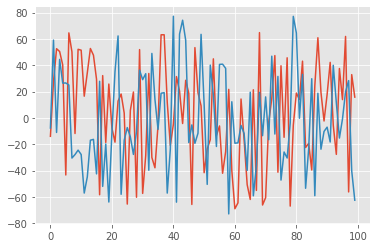

In [48]:
%matplotlib inline
latent
plt.plot(latent[0:100])

In [47]:
print(posterior_small.raw_data())

(<7341x56392 sparse matrix of type '<class 'numpy.float32'>'
	with 28358194 stored elements in Compressed Sparse Row format>, array([22, 64, 62, ..., 56,  8, 22], dtype=uint16))


In [55]:
np.unique(data_small.labels)

array([ 8, 15, 22, 50, 56, 62, 64], dtype=uint16)